### (PSL) Coding Assignment 1

#### Background

This assignment is related to the simulation study described in Section 2.3.1 (the so-called Scenario 2 or Example 2) of "Elements of Statistical Learning" (ESL).

#### The Scenario 2

The two-dimensional data $X \in R^2$ in each class are generated from a mixture of 10 different bivariate Gaussian distributions with uncorrelated components and different means, i.e.,

$$X | Y = k, Z = j \sim \mathcal{N}(\mathbf{m}_{kj}, s^2 I_2)$$

where $k = 0, 1,$ and $j = 1, 2, \ldots, 10$. Set

$$P(Y = k) = 1/2, \quad P(Z = j) = 1/10, \quad s^2 = 1/5.$$

In other words, given $Y = k$, $X$ follows a mixture distribution with probability density function (PDF)

$$\frac{1}{10} \sum_{j=1}^{10} \left(\frac{1}{\sqrt{2\pi s^2}}\right)^2 e^{-\|\mathbf{x}-\mathbf{m}_{kj}\|^2/(2s^2)}.$$

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pprint as pp

#### Part 1: Generate Data
Generate the 20 centers, 10 for each group.

In [78]:
csize = 10      
p = 2      
s = 1;      # sd for generating the centers within each class                    
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])

In [79]:
# 20 centers from two-dimensional normal distribution
# 10 for each group (2 classes)
print(m1)
print(m0)

[[ 1.11902514  1.27654477]
 [ 0.23488103 -0.14010215]
 [ 1.07079797 -0.14332323]
 [ 1.12800381  0.36384979]
 [ 1.47082407 -1.05505052]
 [ 1.59194683  1.42562046]
 [ 1.56209694  1.68335471]
 [ 0.33761715 -0.50948862]
 [ 0.39002502 -0.60374389]
 [ 0.4784736  -0.56833959]]
[[ 0.18024577  0.4836531 ]
 [ 0.73510838  1.08118523]
 [-0.79052171  1.77816912]
 [-2.20338989  0.09412799]
 [-0.24680275  0.41603117]
 [ 0.81608192 -0.43388176]
 [-1.39841695  1.46131256]
 [ 1.06803097  1.69084255]
 [ 0.04027025  0.06485128]
 [-1.21765737  0.56969956]]


In [80]:
# sd for generating both training and test data   
s = np.sqrt(float(1)/5) 

# Gerernating training data
# Randomly allocate the n samples for class 1 to the 10 clusters
n_train = 100
id1_train = np.random.randint(csize, size = n_train)
id0_train = np.random.randint(csize, size = n_train)

# Generate the training data
X_train = np.random.normal(size = (2 * n_train, p)) * s \
            + np.concatenate([m1[id1_train,:], m0[id0_train,:]])
y_train = np.concatenate(([1]*n_train, [0]*n_train))

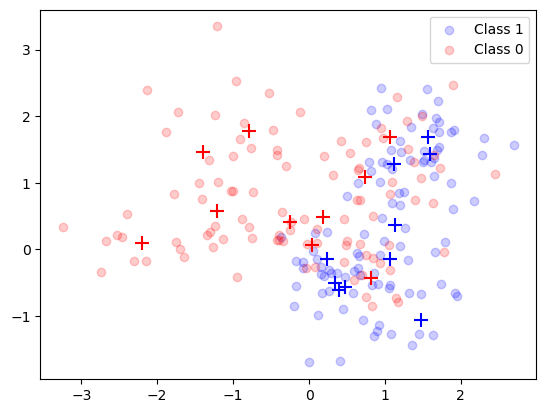

In [81]:
# Visualize the training data
plt.scatter(X_train[:n_train, 0], X_train[:n_train, 1],
            c="blue", alpha=0.2, label='Class 1')
plt.scatter(X_train[n_train:, 0], X_train[n_train:, 1],
            c="red", alpha=0.2, label='Class 0')

plt.scatter(m1[:, 0], m1[:, 1], marker='+', s=100, c="blue")
plt.scatter(m0[:, 0], m0[:, 1], marker='+', s=100, c="red")

plt.legend()
plt.show()

In [82]:
# Generate the test data
n_test = 5000
id1_test = np.random.randint(csize, size = n_test)
id0_test = np.random.randint(csize, size = n_test)

# Generate the test data
X_test = np.random.normal(size = (2 * n_test, p)) * s \
            + np.concatenate([m1[id1_test,:], m0[id0_test,:]])
y_test = np.concatenate(([1]*n_test, [0]*n_test))

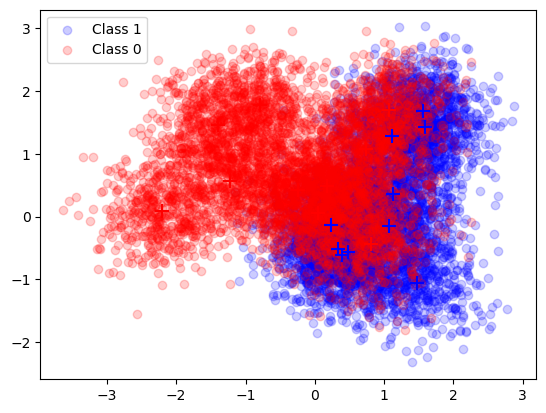

In [83]:
# Visualize the test data (optional)
plt.scatter(X_test[:n_test, 0], X_test[:n_test, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(X_test[n_test:, 0], X_test[n_test:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

#### Part 2: kNN

Handling ties
- Distance ties: Ignored by sorting the distance and only take the first k results
- Voting ties: Using the majority votes to pick the class or use random choice when K is even.

In [84]:

import numpy as np
from collections import Counter
class kNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        # Compute the Euclidean distance with vectorization
        # Reference: https://jaykmody.com/blog/distance-matrices-with-numpy/
        x2 = np.sum(X**2, axis=1, keepdims=True)
        y2 = np.sum(self.X_train**2, axis=1)
        xy = X @ self.X_train.T
        x2 = x2.reshape(-1, 1)
        dists = np.sqrt(x2 + y2 - 2 * xy)
        
        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(dists, axis=1)[:, :self.k]
        
        # Extract the labels of the k nearest neighbors
        k_nearest_labels = self.y_train[k_indices]
        
        # Determine the most common class label among the k neighbors
        return np.apply_along_axis(self._handle_ties, axis=1, arr=k_nearest_labels)

    def _handle_ties(self, k_nearest_labels):
        class_counts = Counter(k_nearest_labels)
        most_common = class_counts.most_common()
        # Handle voting ties
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            return np.random.choice([label for label, count in most_common])
        return most_common[0][0]

In [85]:
# Test the kNN implementation
num_folds = [1, 3, 5]
results = {}
for k in num_folds:
    knn = kNN(k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    results[k] = y_pred


### Confusion matrix

The confusion matrix is a 2x2 matrix for binary classification:

|                   | Predicted Negative | Predicted Positive |
|-------------------|---------------------|---------------------|
| Actual Negative   |         TN          |         FP          |
| Actual Positive   |         FN          |         TP          |

Where:
- TN (True Negative): Correctly predicted negative class
- FP (False Positive): Incorrectly predicted positive class
- FN (False Negative): Incorrectly predicted negative class
- TP (True Positive): Correctly predicted positive class

The matrix provides a comprehensive view of the model's performance, showing both correct and incorrect predictions for each class. The performance of the above self-implemented kNN is same as the one provided by sklearn.

In [86]:
# utility function to print confusion matrix
# with labels
def print_confusion_matrix(cm):
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:")
    print("                | Predicted Negative | Predicted Positive |")
    print("Actual Negative | {:>18} | {:>19}|".format(tn, fp))
    print("Actual Positive | {:>18} | {:>19}|\n".format(fn, tp))

In [87]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# Compute and print confusion matrices for each k value
for k in num_folds:
    y_pred = results[k]
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for k={k} (custom kNN):")
    print_confusion_matrix(cm)


Confusion Matrix for k=1 (custom kNN):
Confusion Matrix:
                | Predicted Negative | Predicted Positive |
Actual Negative |               3702 |                1298|
Actual Positive |               1506 |                3494|

Confusion Matrix for k=3 (custom kNN):
Confusion Matrix:
                | Predicted Negative | Predicted Positive |
Actual Negative |               3684 |                1316|
Actual Positive |               1252 |                3748|

Confusion Matrix for k=5 (custom kNN):
Confusion Matrix:
                | Predicted Negative | Predicted Positive |
Actual Negative |               3654 |                1346|
Actual Positive |                995 |                4005|



In [88]:
# compare this with sklearn.neighbors.KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

for k in num_folds:
    knn_sklearn = KNeighborsClassifier(n_neighbors=k)
    knn_sklearn.fit(X_train, y_train)
    y_pred_sklearn = knn_sklearn.predict(X_test)
    cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
    print(f"Confusion Matrix for k={k} (sklearn):")
    print_confusion_matrix(cm_sklearn)

Confusion Matrix for k=1 (sklearn):
Confusion Matrix:
                | Predicted Negative | Predicted Positive |
Actual Negative |               3702 |                1298|
Actual Positive |               1506 |                3494|

Confusion Matrix for k=3 (sklearn):
Confusion Matrix:
                | Predicted Negative | Predicted Positive |
Actual Negative |               3684 |                1316|
Actual Positive |               1252 |                3748|

Confusion Matrix for k=5 (sklearn):
Confusion Matrix:
                | Predicted Negative | Predicted Positive |
Actual Negative |               3654 |                1346|
Actual Positive |                995 |                4005|



#### Park 3: cvKNN

In [89]:
from sklearn.model_selection import KFold

# Using cross-validation to find the best k
k_values = range(1, 180)
cv_folds = 10
kf = KFold(n_splits=cv_folds)

cv_results = {k: [] for k in k_values}

for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    for k in k_values:
        knn = KNeighborsClassifier(k)  # using sklearn
        knn.fit(X_train_cv, y_train_cv)
        val_predictions = knn.predict(X_val_cv)
        error_rate = np.mean(val_predictions != y_val_cv)
        cv_results[k].append(error_rate)

In [100]:
# get the average cv error for each k and find the minimum
avg_cv_error = {k: np.mean(v) for k, v in cv_results.items()}
min_avg_cv_error = min(avg_cv_error.values())

# find all k with the minimum value and pick the biggest k
best_k = [k for k, v in avg_cv_error.items() if v == min_avg_cv_error]
print("All k values with the minimum value:", best_k)
best_k = max(best_k)

print(f"Best k: {best_k} with average cv error: {min_avg_cv_error}")

All k values with the minimum value: [19, 23, 49, 51]
Best k: 51 with average cv error: 0.29


In [101]:
# Retrain with the best k and evaluate on test data
knn_final = KNeighborsClassifier(best_k)  # using sklearn
knn_final.fit(X_train, y_train)
predictions_test = knn_final.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_test)

print(f"Best k: {best_k}")
print("Confusion Matrix on Test Data:")
print_confusion_matrix(conf_matrix)

Best k: 51
Confusion Matrix on Test Data:
Confusion Matrix:
                | Predicted Negative | Predicted Positive |
Actual Negative |               3149 |                1851|
Actual Positive |                335 |                4665|

